In [1]:
import jax, jaxlib
jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platform_name', 'cpu')

from desilike.likelihoods import ObservablesGaussianLikelihood 
from lightning.pytorch.loggers import WandbLogger 


CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:


import numpy as np
import pandas as pd
import torch
from pathlib import Path

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from sunbird.emulators import FCN
from lightning import Trainer, seed_everything

from pycorr import TwoPointCorrelationFunction
import matplotlib.pyplot as plt

from sunbird.data import ArrayDataModule

import scienceplots
plt.style.use('science')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Load the data

Let's first load the observable we want to fit, in this case the two point correlation function directly measured on the EMC mock

In [5]:
data_dir = Path('/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/')
observed_y = TwoPointCorrelationFunction.load(
    data_dir / 'data_vectors/diffsky/tpcf/z0.5/tpcf_galsampled_diffsky_mock_67120_fixedAmp_001_mass_conc_v0.3.npy'
)
observed_y = observed_y[::4](ells=(0,2),).reshape(-1)

Now let's load the mocks used to estimate the covariance matrix

In [6]:

covariance_path = data_dir / 'covariance/tpcf/z0.5/yuan23_prior/'
n_for_covariance = 1_000
covariance_files = list(covariance_path.glob('*.npy'))[:n_for_covariance]


print(f'Reading {len(covariance_files)} covariance files')
covariance_y = [
    TwoPointCorrelationFunction.load(file)[::4](ells=(0,2),).reshape(-1) for file in covariance_files
]


Reading 1000 covariance files


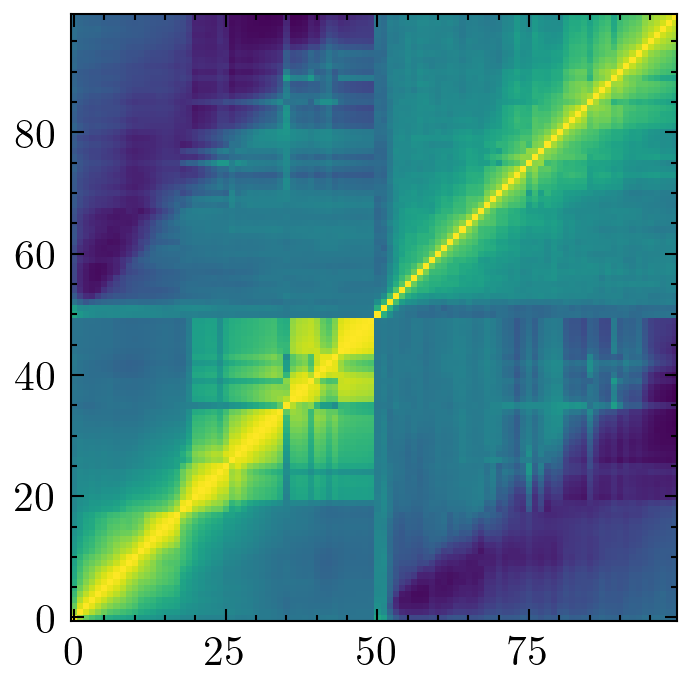

In [7]:
prefactor = 1./8.
covariance_matrix = prefactor * np.cov(np.array(covariance_y).T)

correlation_matrix = np.corrcoef(np.array(covariance_y).T)

plt.imshow(correlation_matrix, origin='lower')

In [8]:
precision_matrix = np.linalg.inv(covariance_matrix)

And now let's read in the sampled HOD parameters and the tpcfs from the training set

In [9]:
lhc_y = np.load(data_dir / 'training_sets/tpcf/z0.5/yuan23_prior/cosmopower/tpcf.npy', allow_pickle=True,).item()
s = lhc_y['s']
lhc_y = lhc_y['multipoles']
lhc_x = pd.read_csv(data_dir / 'hod_params/yuan23/hod_params_yuan23_c000.csv')
lhc_x_names = list(lhc_x.columns)
lhc_x_names = [name.replace(' ', '').replace('#', '') for name in lhc_x_names]
lhc_x = lhc_x.values[:len(lhc_y),:]

print(lhc_x.shape, lhc_y.shape, s.shape)


# let's keep a few points for testing the model
lhc_train_y = lhc_y[:-100]
lhc_train_x = lhc_x[:-100]

lhc_test_y = lhc_y[-100:]
lhc_test_x = lhc_x[-100:]

(30000, 12) (30000, 100) (50,)


let's plot everything together to check that it makes sense

Text(0, 0.5, '$r^2 \\xi(r)$')

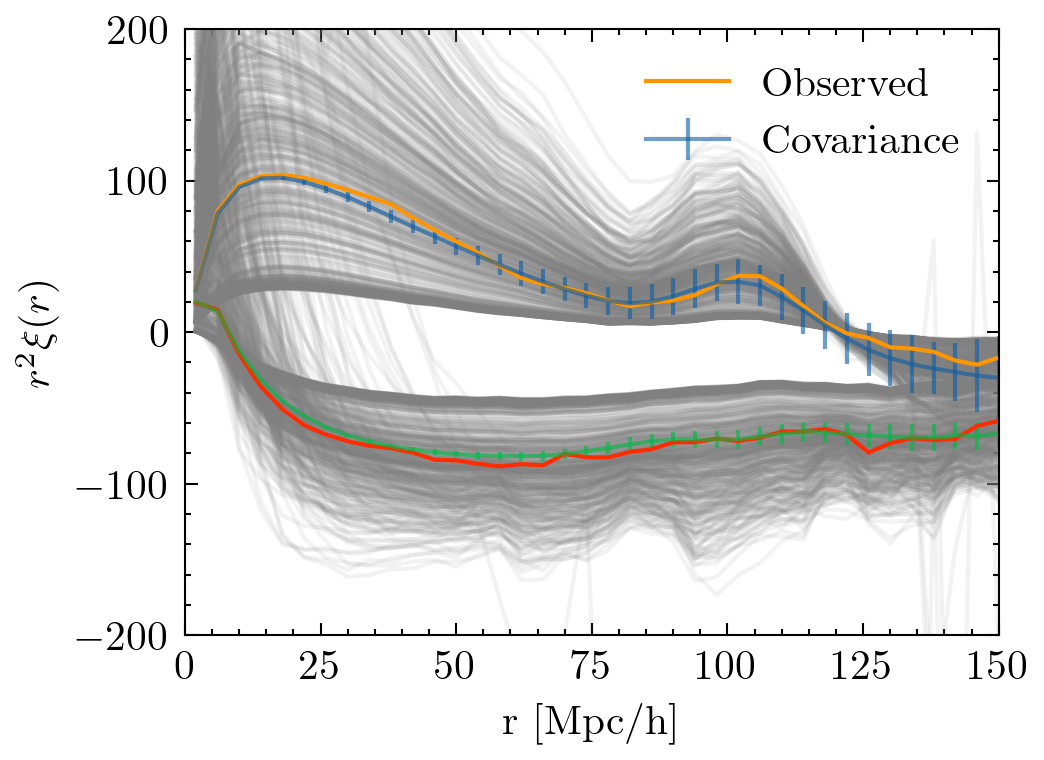

In [10]:
for i in range(500):
    plt.plot(
        s,
        s**2*lhc_y[i,:50],
        color='gray',
        alpha=0.1,
    )
    plt.plot(
        s,
        s**2*lhc_y[i,50:],
        color='gray',
        alpha=0.1,
    )

plt.errorbar(
    s, 
    s**2*np.mean(covariance_y, axis=0)[:50], 
    yerr=s**2*np.sqrt(np.diag(covariance_matrix)[:50]),
    label='Covariance', 
    alpha=0.6,
)
plt.errorbar(
    s, 
    s**2*np.mean(covariance_y, axis=0)[50:], 
    yerr=s**2*np.sqrt(np.diag(covariance_matrix)[50:]),
    alpha=0.6,
)

plt.plot(s, s**2*observed_y[:50], label='Observed')
plt.plot(s, s**2*observed_y[50:])


plt.legend()
plt.xlim(0,150)
plt.ylim(-200,200)
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$r^2 \xi(r)$')

## Train an emulator

In [11]:
batch_size = 256
num_workers = 4
train_mean = np.mean(lhc_y, axis=0)
train_std = np.std(lhc_y, axis=0)

train_mean_x = np.mean(lhc_x, axis=0)
train_std_x = np.std(lhc_x, axis=0)


lhc_x_standarized = (lhc_x - train_mean_x) / train_std_x
lhc_y_standarized = (lhc_y - train_mean) / train_std
dm = ArrayDataModule(
    torch.Tensor(lhc_x_standarized), 
    torch.Tensor(lhc_y_standarized), 
    val_fraction=0.1, 
    batch_size=batch_size,
    num_workers=num_workers,
)
dm.setup()

In [12]:
def fit(**kwargs):
    early_stop_callback = EarlyStopping(
        monitor="val_loss", 
        patience=kwargs['early_stop_patience'], 
        min_delta=kwargs['early_stop_threshold'],
        mode="min", 
        verbose=True, 
        check_on_train_epoch_end=True,
    )
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='my_model_checkpoints',
        filename='best-model-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,
        mode='min',
    )
    lr_monitor = LearningRateMonitor(logging_interval='step')

    model = FCN(
        n_input=dm.n_input,
        n_output=dm.n_output,
        n_hidden=kwargs['n_hidden'],
        dropout_rate=kwargs['dropout_rate'],
        learning_rate=kwargs['learning_rate'],
        scheduler_patience=kwargs['scheduler_patience'],
        scheduler_factor=kwargs['scheduler_factor'],
        scheduler_threshold=kwargs['scheduler_threshold'],
        weight_decay=kwargs['weight_decay'],
        act_fn='learned_sigmoid', #'SiLU',
        loss='rmse',
        load_loss=True,
        output_transforms=None,
        log=True,
        mean_output = train_mean,
        std_output = train_std,
    )

    seed_everything(42, workers=True)

    logger = WandbLogger(log_model="all", project="sunbird")

    trainer = Trainer(
        accelerator="auto",
        callbacks=[early_stop_callback, checkpoint_callback, lr_monitor],
        gradient_clip_val=0.5,
        deterministic=True,
        max_epochs=1_000,
        logger=logger,
        check_val_every_n_epoch=1,
    )
    trainer.fit(
        model=model,
        #datamodule=dm,
        train_dataloaders=dm.train_dataloader(),
        val_dataloaders=dm.val_dataloader(),
    )
    best_val_epoch = early_stop_callback.best_score.item()
    weights_dict = torch.load(
        checkpoint_callback.best_model_path,
        map_location=torch.device("cpu"),
    )
    state_dict = weights_dict["state_dict"]
    model.load_state_dict(state_dict, strict=True)
    return best_val_epoch, model, early_stop_callback

In [13]:
val_loss, model, early_stop_callback = fit(
    n_hidden=[512, 512, 512, 512,], 
    dropout_rate=0., 
    learning_rate=1.e-3,
    scheduler_patience=30,
    scheduler_factor=0.5,
    scheduler_threshold=1.e-6,
    weight_decay=0.,
    early_stop_patience=50,
    early_stop_threshold=1.e-7,
    #val_check_interval=1,
)

[rank: 0] Seed set to 42


/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /n/holystore01/LABS/iaifi_lab/Lab/environments/carol ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /n/holystore01/LABS/iaifi_lab/Lab/environments/carol ...
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To 

/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /n/home11/ccuestalazaro/sunbird/nb/my_model_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 845 K 
------------------------------------
845 K     Trainable params
0         Non-trainable params
845 K     Total params
3.384     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.576


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.177 >= min_delta = 1e-07. New best score: 0.398


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.069 >= min_delta = 1e-07. New best score: 0.330


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 1e-07. New best score: 0.313


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-07. New best score: 0.310


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 1e-07. New best score: 0.286


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-07. New best score: 0.285


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 1e-07. New best score: 0.281


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 1e-07. New best score: 0.255


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 1e-07. New best score: 0.246


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 1e-07. New best score: 0.209


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 1e-07. New best score: 0.202


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 1e-07. New best score: 0.176


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 1e-07. New best score: 0.170


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 1e-07. New best score: 0.154


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 1e-07. New best score: 0.149


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 1e-07. New best score: 0.136


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 1e-07. New best score: 0.132


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-07. New best score: 0.128


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-07. New best score: 0.126


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 1e-07. New best score: 0.111


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 1e-07. New best score: 0.103


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 1e-07. New best score: 0.098


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 1e-07. New best score: 0.090


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 1e-07. New best score: 0.079


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 1e-07. New best score: 0.071


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-07. New best score: 0.070


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-07. New best score: 0.070


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 1e-07. New best score: 0.066


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-07. New best score: 0.064


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 1e-07. New best score: 0.060


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-07. New best score: 0.060


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-07. New best score: 0.059


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-07. New best score: 0.058


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-07. New best score: 0.057


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 50 records. Best score: 0.057. Signaling Trainer to stop.


In [21]:
print('best score = ', early_stop_callback.best_score.item())
print('stopped epoch = ', early_stop_callback.stopped_epoch)
print('wait count = ', early_stop_callback.wait_count)


best score =  0.056507401168346405
stopped epoch =  392
wait count =  50


In [22]:
val_loss

0.056507401168346405

In [23]:
lhc_x_test_standarized = (lhc_test_x - train_mean_x) / train_std_x

In [24]:
model.eval()
model = model.cpu()
with torch.no_grad():
    pred_test_y, _ = model(torch.Tensor(lhc_x_test_standarized))
pred_test_y = pred_test_y.numpy()
pred_test_y = pred_test_y * train_std + train_mean

In [25]:
emulator_error = (pred_test_y - lhc_test_y)/np.sqrt(np.diag(covariance_matrix))
print(emulator_error.shape)
q68 = np.quantile(emulator_error, [0.16, 0.84], axis=0)
q95 = np.quantile(emulator_error, [0.025, 0.975], axis=0)
q99 = np.quantile(emulator_error, [0.005, 0.995], axis=0)

(100, 100)


In [26]:
print(q68.shape)

(2, 100)


<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/tmp/ipykernel_3578231/1772135631.py:1: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(list(range(len(observed_y))), q95[0], q95[1], alpha=0.5, label='95\%', color='C1')
/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/tmp/ipykernel_3578231/1772135631.py:2: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(list(range(len(observed_y))), q68[0], q68[1], alpha=0.5, label='68\%', color='C0')


(-3.0, 3.0)

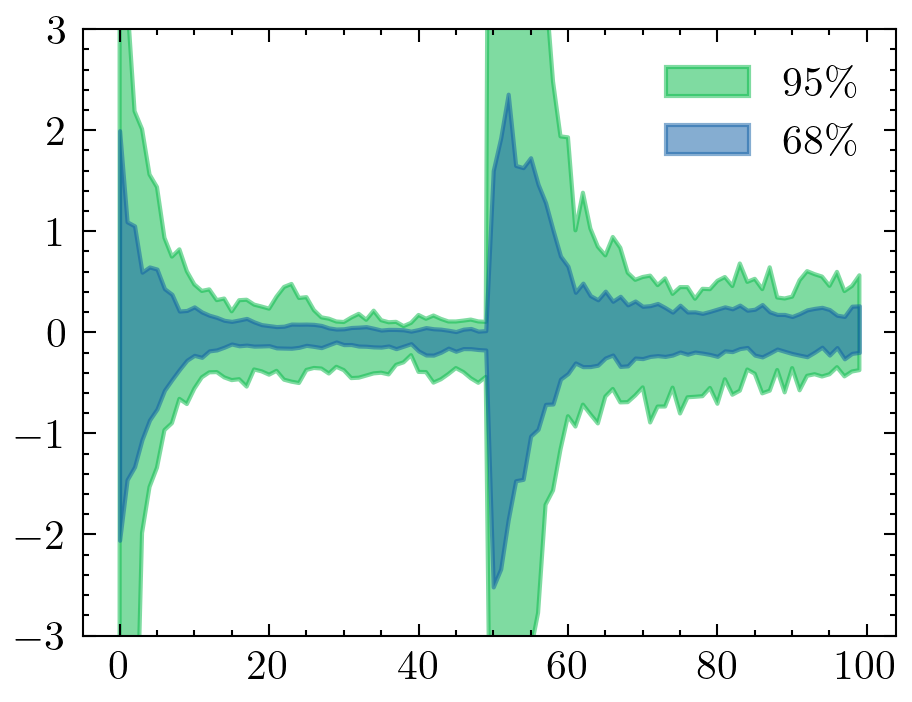

In [27]:

plt.fill_between(list(range(len(observed_y))), q95[0], q95[1], alpha=0.5, label='95\%', color='C1')
plt.fill_between(list(range(len(observed_y))), q68[0], q68[1], alpha=0.5, label='68\%', color='C0')
plt.legend()
plt.ylim(-3,3)

<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/tmp/ipykernel_1947590/1772135631.py:1: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(list(range(len(observed_y))), q95[0], q95[1], alpha=0.5, label='95\%', color='C1')
/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/tmp/ipykernel_1947590/1772135631.py:2: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(list(range(len(observed_y))), q68[0], q68[1], alpha=0.5, label='68\%', color='C0')


(-3.0, 3.0)

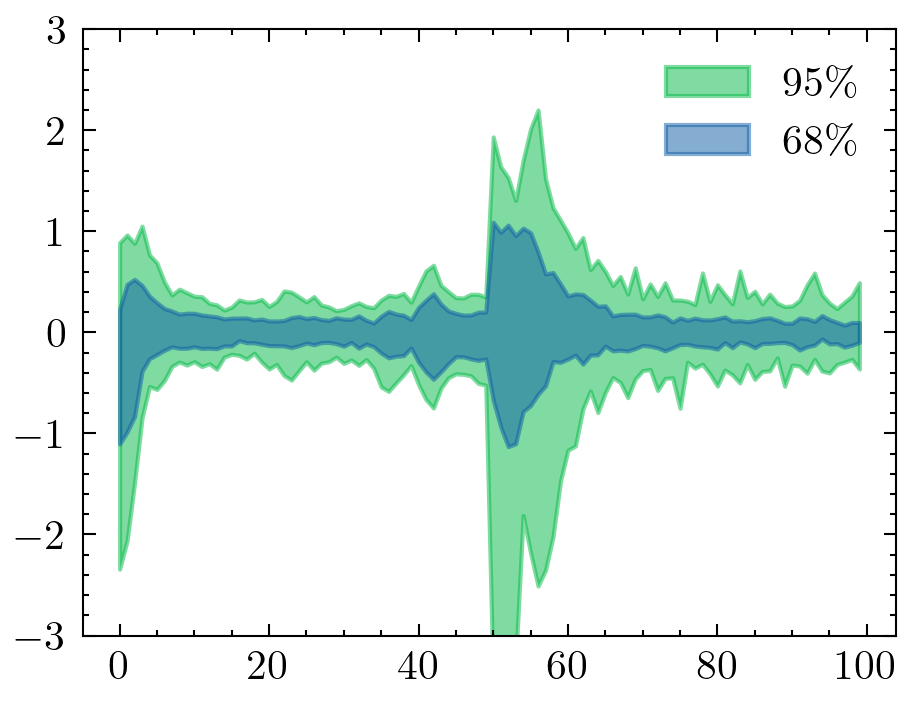

In [ ]:

plt.fill_between(list(range(len(observed_y))), q95[0], q95[1], alpha=0.5, label='95\%', color='C1')
plt.fill_between(list(range(len(observed_y))), q68[0], q68[1], alpha=0.5, label='68\%', color='C0')
plt.legend()
plt.ylim(-3,3)

Text(0, 0.5, '$r^2 \\xi(r)$')

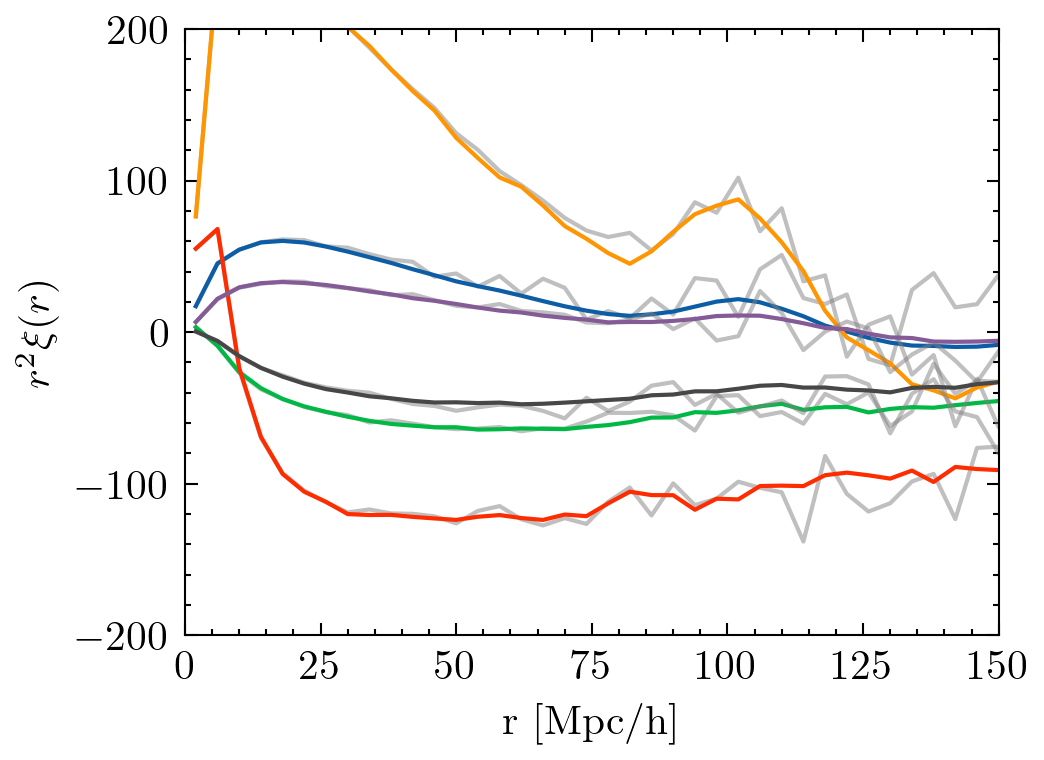

In [23]:

for i in range(3):
    plt.plot(
        s,
        s**2*pred_test_y[i,:50],
        color='gray',
        alpha=0.5,
    )
    plt.plot(
        s,
        s**2*pred_test_y[i,50:],
        color='gray',
        alpha=0.5,
    )

    plt.plot(s, s**2*lhc_test_y[i,:50], label='Observed')
    plt.plot(s, s**2*lhc_test_y[i,50:])


plt.xlim(0,150)
plt.ylim(-200,200)
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$r^2 \xi(r)$')

In [ ]:
# turn torch model into flax/jax so that we can use it with an HMC in desilike
nn_model, flax_params = model.to_jax()

In [ ]:
import numpyro
from numpyro import infer
from numpyro import distributions as dist
from jax import random

ModuleNotFoundError: No module named 'numpyro'

In [ ]:
class HMC:
    def __init__(
        self,
        nn_theory_model,
        nn_parameters,
        observation,
        priors,
        precision_matrix,
    ):
        self.nn_theory_model = nn_theory_model
        self.nn_parameters = nn_parameters 
        self.observation = observation
        self.priors = priors
        self.precision_matrix = precision_matrix 

    def sample_prior(
        self,
    ) -> Dict[str, float]:
        """Sample a set of parameters from the prior

        Returns:
            Dict: dictionary of parameters
        """
        x = np.ones(len(self.priors.keys()))
        for i, param in enumerate(self.priors.keys()):
            x = x.at[i].set(
                numpyro.sample(
                    param,
                    self.priors[param],
                )
            )
        return x

    def sanity_check_prior(self, n_samples=10,):
        predictions = []
        for i in range(n_samples):
            x = self.sample_prior()
            x = (x - train_mean_x) / train_std_x
            prediction = self.theory_model.apply(
                x,
            )
            predictions.append(prediction * train_std + train_mean)
        return predictions

    def model(
        self,
        y: np.array,
    ):
        """Likelihood evaluation for the HMC inference

        Args:
            y (np.array): array with observation
        """
        x = self.sample_prior()
        # standarize it
        x = (x - train_mean_x) / train_std_x
        prediction = self.theory_model.apply(
            x,
        )
        # destandarize it
        prediction = prediction * train_std + train_mean
        numpyro.sample(
            "y", dist.MultivariateNormal(prediction, precision_matrix=self.precision_matrix), obs=y
        )


    def __call__(
        self,
        kernel: str = "NUTS",
        num_warmup: int = 100,
        num_samples: int = 1000,
    ):
        """Run the HMC inference

        Args:
            kernel (str, optional): kernel used for HMC. Defaults to "NUTS".
            num_warmup (int, optional): number of warmup steps. Defaults to 500.
            num_samples (int, optional): numper of samples. Defaults to 1000.
        """
        kernel = getattr(infer, kernel)(self.model)
        mcmc = infer.MCMC(
            kernel,
            num_warmup=num_warmup,
            num_samples=num_samples,
        )
        rng_key = random.PRNGKey(0)
        mcmc.run(
            rng_key,
            y=self.observation,
            extra_fields=['potential_energy'],
        )
        mcmc.print_summary()
        results = mcmc.get_samples()
        return results



In [ ]:
idx_to_fit = 10
observation = lhc_test_y[idx_to_fit]
true_params = lhc_test_x[idx_to_fit]

In [ ]:
lhc_x_names

In [ ]:
priors = {
    'logM1': dist.Uniform(low=13.6, high=15.1),
    'logM_cut': dist.Uniform(low=12.4, high=13.7),
    'alpha': dist.Uniform(low=0.3, high=1.5),
    'alpha_s': dist.Uniform(low=0.5, high=1.5),
    'alpha_c': dist.Uniform(low=0., high=0.5),
    'sigma': dist.Uniform(low=-3., high=1.),
    'kappa': dist.Uniform(low=0., high=1.),
    'B_cen': dist.Uniform(low=-0.7, high=0.2),
    'B_sat': dist.Uniform(low=-1., high=1.),
    'A_cen': dist.Uniform(low=-1., high=1.),
    'A_sat': dist.Uniform(low=-1., high=1.),
    's': dist.Uniform(low=-1., high=1.),
}

In [ ]:
hmc = HMC(
    nn_model,
    flax_params,
    observation,
    priors,
    precision_matrix,
)

In [ ]:

# First test, make sure sampling the prior is sensible (envelopes the data)
samples = hmc.sanity_check_prior()
for sample in samples:
    plt.plot(
        s,
        s**2*sample[:50],
        color='gray',
        alpha=0.5,
    )
    plt.plot(
        s,
        s**2*sample[50:],
        color='gray',
        alpha=0.5,
    )

plt.plot(s, s**2*observation[:50], label='Observed')
plt.plot(s, s**2*observation[50:])


plt.xlim(0,150)
plt.ylim(-200,200)
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$r^2 \xi(r)$')

In [ ]:
results = hmc()

In [ ]:
results

In [ ]:
chain_getdist = MCSamples(
        samples=chain,
        weights=None,
        labels=[labels[n] for n in names],
        names=lhc_x_names,
        ranges=priors,
    )

In [ ]:
from getdist import plots
g = plots.get_subplot_plotter()
g.settings.constrained_layout = True
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = ":"
g.settings.title_limit_labels = False
g.settings.axis_marker_color = "k"
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth_contour = 1.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6

g.triangle_plot(
    roots=[chain_getdist],
    #params=['logM_1', 'logM_cut', 'alpha', 'alpha_s', 'alpha_c', 'sigma'],
    filled=True,
)
plt.show()

In [ ]:
def get_ranks(
    posterior_samples_array,
    theta,
):
    n_posteriors = theta.shape[0]
    ndim = theta.shape[1]
    ranks, mus, stds = [], [], []
    for i in range(n_posteriors):
        posterior_samples = posterior_samples_array[i]
        mu, std = posterior_samples[i].mean(axis=0), posterior_samples.std(axis=0)
        rank = [(posterior_samples[:, j] < theta[i, j]).sum() for j in range(ndim)]
        mus.append(mu)
        stds.append(std)
        ranks.append(rank)
    mus, stds, ranks = np.array(mus), np.array(stds), np.array(ranks)
    return mus, stds, ranks


def plot_coverage(ranks, labels, plotscatter=True):
    ncounts = ranks.shape[0]
    npars = ranks.shape[-1]
    unicov = [np.sort(np.random.uniform(0, 1, ncounts)) for j in range(30)]

    fig, ax = plt.subplots(
        figsize=(3.5, 2.6),
    )
    ax.axvline(x=0.68, color="lightgray", alpha=0.3)
    cmap = matplotlib.cm.get_cmap("coolwarm")
    colors = cmap(np.linspace(0.01, 0.99, len(labels)))

    for i in range(npars):
        xr = np.sort(ranks[:, i])
        xr = xr / xr[-1]
        cdf = np.arange(xr.size) / xr.size
        ax.plot(xr, cdf, lw=1.25, label=labels[i], color=colors[i])
    ax.set_xlabel("Confidence Level")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3)
    ax.set_ylabel("Empirical Coverage")
    ax.text(
        0.1,
        0.85,
        "Conservative",
        ha="left",
        va="top",
        transform=ax.transAxes,
        style="italic",
        fontsize=9,
    )
    ax.text(
        0.9,
        0.15,
        "Overconfident",
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        style="italic",
        fontsize=9,
    )
    if plotscatter:
        for j in range(len(unicov)):
            ax.plot(unicov[j], cdf, lw=1, color="gray", alpha=0.2)
    return ax


In [ ]:
# now fit Gillian's mocks

In [ ]:
lhc_test_y.shape

In [ ]:
results

In [ ]:
# optuna model
import optuna

def objective(trial, args):
    lr = trial.suggest_float(
        "learning_rate",
        1.0e-4,
        0.01,
    )
    weight_decay = trial.suggest_float("weight_decay", 1.0e-5, 0.001)
    n_layers = trial.suggest_int("n_layers", 1, 10)
    n_hidden = [
            trial.suggest_int(f"n_hidden_{layer}", 200, 1024)
            for layer in range(n_layers)
        ]
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.15)
    args.learning_rate = lr
    args.weight_decay = weight_decay
    args.n_hidden = n_hidden
    args.dropout_rate = dropout_rate
    return fit()

n_trials = 50
study = optuna.create_study()
optimize_objective = lambda trial: objective(trial,)
study.optimize(optimize_objective, n_trials=n_trials)



In [ ]:

# optuna topk models

## Run fast inference by taking advantage of the gradients

Note that we will ignore the emulator errors, but if sizable they should be included in the covariance

In [ ]:
# turn torch model into flax/jax so that we can use it with an HMC in desilike
nn_model, flax_params = model.to_jax()

In [ ]:
from sunbird.theory.theory import SunbirdTheoryEmulator
from desilike.base import BaseCalculator

In [ ]:
emu = SunbirdTheoryEmulator(nn_model, flax_params, lhc_x_names)

In [ ]:
class SunbirdObservable(BaseCalculator):
    def initialize(self, data, theory):
        self.data = data
        self.theory = theory

    @property
    def flatdata(self):
        return self.data

    def calculate(self, **kwargs):
        self.flattheory = self.theory.get()

In [ ]:
observable = SunbirdObservable(data=lhc_test_y[0], theory=emu)

In [ ]:
likelihood = ObservablesGaussianLikelihood(
    observables=[observable,], 
    covariance=covariance_matrix,
)

In [ ]:

loglikelihood = likelihood(logM_cut=13.5)

In [ ]:
loglikelihood

Array(-39085983.85644864, dtype=float64)

In [ ]:
print('holi')

In [ ]:
from desilike import setup_logging

setup_logging() 
likelihood.runtime_info.pipeline.calculators

In [ ]:
likelihood()

Array(-39085983.85644864, dtype=float64)

In [ ]:
from desilike.samplers import NUTSSampler

step_size = 1e-3
sampler = NUTSSampler(likelihood, seed=42,step_size=step_size)
chains = sampler.run(max_iterations=5000)

[000001.45] [0/1] 03-20 14:34  NUTSSampler               INFO     Varied parameters: ['logM_1', 'logM_cut', 'alpha', 'alpha_s', 'alpha_c', 'sigma', 'kappa', 'B_cen', 'B_sat', 'A_cen', 'A_sat', 's'].
[000008.74] [0/1] 03-20 14:34  NUTSSampler               INFO     Successfully vmap input likelihood.
[000008.92] [0/1] 03-20 14:34  NUTSSampler               INFO     Successfully jit input likelihood.
[000009.09] [0/1] 03-20 14:34  TaskManager               INFO     Entering TaskManager with 1 workers.
[000014.67] [0/1] 03-20 14:34  NUTSSampler               INFO     Using hyperparameters: {'step_size': Array(1.52123372e-05, dtype=float64, weak_type=True), 'inverse_mass_matrix': Array([9.90709198e-06, 1.13355860e-05, 9.90107366e-06, 9.91370750e-06,
       9.90118432e-06, 9.90102413e-06, 9.90104608e-06, 1.03793948e-05,
       9.91920040e-06, 9.91054794e-06, 9.90099218e-06, 9.90099029e-06],      dtype=float64)}.
[000018.40] [0/1] 03-20 14:34  TaskManager               INFO     Entering Task

In [ ]:
chains[0].shape

(5000,)

In [ ]:
#from desilike.samplers import StaticDynestySampler

#sampler = StaticDynestySampler(likelihood, save_fn='.',)
#chains = sampler.run()

In [ ]:
chain = chains[0].remove_burnin(0.5)

print(chain.to_stats(tablefmt='pretty'))

+----------+------------+------------+------------+--------+-----------------+-------------------+
|          |   argmax   |    mean    |   median   |  std   | quantile:1sigma |  interval:1sigma  |
+----------+------------+------------+------------+--------+-----------------+-------------------+
|  logM_1  |  14.28889  |  14.28869  |  14.28868  | 1.1e-4 | -1.3e-4/+1.3e-4 | -5.8e-5/+1.88e-4  |
| logM_cut |  13.3575   |  13.3608   |  13.3607   | 0.0019 | -0.0021/+0.0022 | -0.00308/+0.00100 |
|  alpha   |  0.381647  |  0.381672  |  0.381671  | 1.8e-5 | -2.0e-5/+2.1e-5 | -2.62e-5/+5.9e-6  |
| alpha_s  |  0.82924   |  0.82897   |  0.82897   | 1.6e-4 | -1.9e-4/+1.8e-4 | -8.5e-5/+2.58e-4  |
| alpha_c  |  0.289520  |  0.289556  |  0.289560  | 2.0e-5 | -2.7e-5/+2.1e-5 |  -1.2e-5/+2.9e-5  |
|  sigma   | -1.8067267 | -1.8067196 | -1.8067187 | 4.4e-6 | -4.9e-6/+4.6e-6 |  -3.9e-6/+5.2e-6  |
|  kappa   |  0.211326  |  0.211352  |  0.211354  | 1.3e-5 | -1.3e-5/+1.5e-5 |  -1.1e-5/+1.6e-5  |
|  B_cen  

In [ ]:
chain.shape

(2500,)

In [ ]:

chain_plot = chain.to_getdist()

Removed no burn in


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
from getdist import plots
g = plots.get_subplot_plotter()
g.settings.constrained_layout = True
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = ":"
g.settings.title_limit_labels = False
g.settings.axis_marker_color = "k"
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth_contour = 1.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6

g.triangle_plot(
    roots=[chain_plot],
    #params=['logM_1', 'logM_cut', 'alpha', 'alpha_s', 'alpha_c', 'sigma'],
    filled=True,
)
plt.show()

[000070.61] [0/1] 03-20 14:35  root                      WARNING  2D kernel density bandwidth optimizer failed for logM_1, A_sat. Using fallback width: f(a) and f(b) must have different signs
[000075.47] [0/1] 03-20 14:35  root                      WARNING  2D kernel density bandwidth optimizer failed for logM_cut, A_sat. Using fallback width: f(a) and f(b) must have different signs
[000081.82] [0/1] 03-20 14:35  root                      WARNING  2D kernel density bandwidth optimizer failed for alpha_s, A_sat. Using fallback width: f(a) and f(b) must have different signs
[000089.24] [0/1] 03-20 14:35  root                      WARNING  2D kernel density bandwidth optimizer failed for sigma, kappa. Using fallback width: f(a) and f(b) must have different signs
[000094.72] [0/1] 03-20 14:35  root                      WARNING  2D kernel density bandwidth optimizer failed for B_cen, A_sat. Using fallback width: f(a) and f(b) must have different signs
[000096.25] [0/1] 03-20 14:35  root    

KeyboardInterrupt: 